# Proyecto Final: Construcción de Portafolios de Inversión
# Universidad Nacional Autónoma de México
## Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas


Tutoriales: 
El paso a paso para usar yfinance: https://analyzingalpha.com/yfinance-python#Download_Fundamentals_for_Multiple_Tickers_Using_yfinance

## Preeliminares

In [ ]:
!pip install yfinance
!pip install pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Bibliotecas
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from tqdm import tqdm
from itertools import compress
import seaborn as sns
sns.set_theme()

## Algoritmos de No-Dominancia

In [ ]:
def get_best_opt(data_portf,  n_feat, tol):
  portfolios = data_portf.iloc[:, :n_feat]
  portfolios = portfolios.to_numpy()
  indx = data_portf.index
  A = np.array( [[np.inf]*n_feat])
  best_idx = [np.inf]
  for idx,row in tqdm(zip(indx,portfolios)):
    test1 = (A <= row).all(axis=1)
    test2 = np.linalg.norm(A-row, ord=2, axis=1) > tol
    if not ((test1) & (test2)).any(): 
      A = np.vstack([A,row])
      best_idx.append(idx)
      test1 = (row <= A).all(axis=1)
      test2 = np.linalg.norm(row- A, ord=2, axis=1)> tol
      A = A[~((test1) & (test2)) ,:]
      best_idx = list(compress(best_idx,~((test1) & (test2))))
  return pd.DataFrame(A, index=best_idx, columns=data_portf.columns[:n_feat])

In [ ]:
#Se crea una función para verificar la completitud de las variables de la base.
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"variable",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

## Análisis sobre S&P500

### Obtención de componentes 

https://www.slickcharts.com/sp500

In [ ]:
sp500_data =pd.read_excel('DJ30.xlsx')
sp500_data

,#,Company,Symbol
0,1,UnitedHealth Group Incorporated,UNH
1,2,Goldman Sachs Group Inc.,GS
2,3,Home Depot Inc.,HD
3,4,Amgen Inc.,AMGN
4,5,McDonald's Corporation,MCD
5,6,Microsoft Corporation,MSFT
6,7,Caterpillar Inc.,CAT
7,8,Honeywell International Inc.,HON
8,9,Visa Inc. Class A,V
9,10,Travelers Companies Inc.,TRV


In [ ]:
#Nos quedamos solo con el símbolo de la compañía
sp_list = sp500_data['Symbol'].to_list()
print(sp_list[:10])

['UNH', 'GS', 'HD', 'AMGN', 'MCD', 'MSFT', 'CAT', 'HON', 'V', 'TRV']


### Obtención de datos históricos

In [ ]:
#Descargamos la información para cada activo desde yfinance
ohlc = yf.download(sp_list, period="2y")

[*********************100%***********************]  30 of 30 completed


In [ ]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.shape

(504, 30)

In [ ]:
prices.tail(3)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-29,141.169998,281.989990,154.419998,175.320007,235.119995,151.679993,48.279999,181.029999,94.690002,50.650002,...,108.839996,240.330002,106.250000,145.479996,187.210007,528.000000,209.059998,38.340000,41.080002,152.970001
2022-11-30,148.029999,286.399994,157.589996,178.880005,236.410004,160.250000,49.720001,183.309998,97.870003,50.970001,...,110.120003,255.139999,109.690002,149.160004,189.809998,547.760010,217.000000,38.980000,41.500000,152.419998
2022-12-01,148.309998,285.940002,157.500000,175.779999,235.690002,147.000000,49.970001,182.490005,98.589996,51.070000,...,109.800003,254.690002,111.110001,149.250000,189.139999,536.909973,217.000000,38.330002,41.310001,153.369995


In [ ]:
#Se descartan las opciones que tienen poco tiempo en el mercado
#(no debería de hacerse mucho enfasis en esta parte)
cc =completitud(prices)
cc.head(5)

,variable,total,completitud
0,IBM,2,99.603175
1,AAPL,0,100.000000
2,VZ,0,100.000000
3,V,0,100.000000
4,UNH,0,100.000000


In [ ]:
sp500_names_reduc = cc[cc['completitud' ]>99]['variable'].values
prices_selection = prices[sp500_names_reduc]

In [ ]:
prices_selection.dropna(inplace=True) #borra nulos
prices_selection.isna().sum().sum()   #revisar que ya no queden más valores nulos

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0

Es importante que el dataset de datos historicos ya no contenga ningún valor faltante para que se pueda sacar matriz de covarianzas y retornos

### Obtención de Datos de Sustentabilidad

No todas las empresas tienen disponible su información sobre ESG en yahoo finance. 
https://finance.yahoo.com/news/guide-understanding-esg-ratings-151501443.html

Se hace scrapping para obtener estos datos, pero se reduce y se excluye a las que no cuentan con esta información para no sesgar el análisis. 

Lo que nos interesa es el TotalEsg, la intención es minimizarlo ( a modo de minimzar daño a la sustentabilidad, medio ambiente, sociedad) sin perder ganancias en los portafolios. 

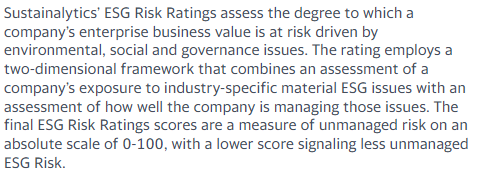

Lo que nos interes

In [ ]:
#Ejemplo para un único activo
dat = yf.Ticker('AAPL')
dat.sustainability.to_dict()['Value']

{'palmOil': False,
 'controversialWeapons': False,
 'gambling': False,
 'socialScore': 6.86,
 'nuclear': False,
 'furLeather': False,
 'alcoholic': False,
 'gmo': False,
 'catholic': False,
 'socialPercentile': None,
 'peerCount': 55,
 'governanceScore': 9.18,
 'environmentPercentile': None,
 'animalTesting': False,
 'tobacco': False,
 'totalEsg': 16.68,
 'highestControversy': 3,
 'esgPerformance': 'UNDER_PERF',
 'coal': False,
 'pesticides': False,
 'adult': False,
 'percentile': 14.68,
 'peerGroup': 'Technology Hardware',
 'smallArms': False,
 'environmentScore': 0.65,
 'governancePercentile': None,
 'militaryContract': False}

In [ ]:
sustainability =[]
fails=0
for asset in tqdm(sp500_names_reduc):
    dat_yf = yf.Ticker(asset)
    if dat_yf.sustainability is None:
      sustainability.append(np.nan) 
    else:
      dat_yf = dat_yf.sustainability.to_dict()['Value']
      sustainability.append( dat_yf.get('totalEsg', np.nan))

100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


In [ ]:
sp500_esgdat = pd.DataFrame({'Symbol':sp500_names_reduc, 'ESGscore':sustainability})

In [ ]:
sp500_esgdat.isna().sum()

Symbol      0
ESGscore    1
dtype: int64

Hay valores que tinen NaN porque no conseguimos información respecto a su sustentabilidad.

### Limpieza de los datos y procesamiento

In [ ]:
#Limpieza de Nans
sp500_esgdat.dropna(inplace=True)
sp500_esgdat.isna().sum().sum()

0

In [ ]:
#Se actualiza el total de activos de los que disponemos
sp500_names_reduc = sp500_esgdat['Symbol'].to_list()
prices_selection = prices_selection.loc[:, sp500_names_reduc]

In [ ]:
#Por si se muere el kernel con estos dos archivos ya se arma
prices_selection.to_csv('prices.csv')
sp500_esgdat.to_csv('esgScore.csv')

Según Wikipedia siempre es mejor trabajar con retornos logaritmicos por la propiedad subaditiva de los mismos, pero me preocupa que el profe no les entienda. 
https://es.wikipedia.org/wiki/Tasa_de_retorno

In [ ]:
#Calculo de rendimientos logaritmicos 
log_rend = prices_selection.copy()
for asset in prices_selection.columns:
  log_rend[asset] =  np.log(prices_selection[asset]/prices_selection[asset].shift(1))

log_rend.dropna(inplace=True)
log_rend.shape

(501, 29)

### Información sobre acada activo

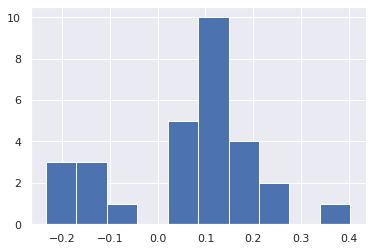

In [ ]:
(log_rend.mean()*252).hist()

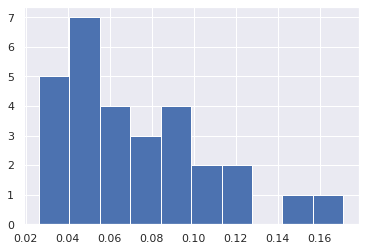

In [ ]:
(log_rend.var()*252).hist()

## Primer Filtrado de Datos (considerando solo Mean -profit-, Variance -Risk-). 

In [ ]:
import pandas as pd
assets_ind_perf=pd.DataFrame()
assets_ind_perf["mean"]=-log_rend.mean()
assets_ind_perf["variance"]=log_rend.std()
assets_ind_perf

,mean,variance
IBM,-0.000587,0.014820
AAPL,-0.000395,0.019389
VZ,0.000723,0.011774
V,-0.000111,0.017436
UNH,-0.000956,0.013751
TRV,-0.000768,0.014051
PG,-0.000263,0.011744
NKE,0.000409,0.021830
MSFT,-0.000384,0.018188
MRK,-0.000832,0.013770


In [ ]:
best_assets = get_best_opt(assets_ind_perf, 2, 1e-12)

29it [00:00, 19823.14it/s]


In [ ]:
#Nos quedamos solo con los activos que no son dominados por ningún otro
best_assets

,mean,variance
UNH,-0.000956,0.013751
MCD,-0.000597,0.011151
JNJ,-0.000456,0.010229
GS,-0.001044,0.017473
CVX,-0.001597,0.018327


In [ ]:
best_assets.shape

(5, 2)

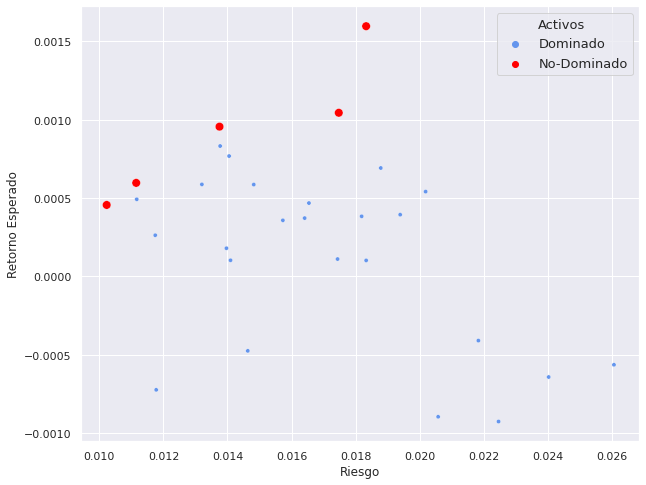

In [ ]:
assets_plot = assets_ind_perf.copy()
assets_plot['Activos'] = 'Dominado'
assets_plot['Size']    = 1000
assets_plot['mean'] = -assets_plot['mean']
assets_plot.loc[best_assets.index,'Activos']='No-Dominado'
assets_plot.loc[best_assets.index,'Size'] = 3000
fig = plt.figure(figsize=(10,8))
g= sns.scatterplot(data=assets_plot, x='variance', y='mean', hue='Activos',
                size='Size' ,palette=['cornflowerblue', 'red'])

h,l = g.get_legend_handles_labels()
plt.legend(h[0:3],l[0:3], loc='best', fontsize=13)
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.show()

In [ ]:
best_assets_l = list(best_assets.index)

In [ ]:
#Nos quedamos con los rendimientos de solo los mejores assets
log_rend_b = log_rend.loc[:, best_assets_l]
sp500_esgdat_b = sp500_esgdat.set_index('Symbol').loc[best_assets_l]

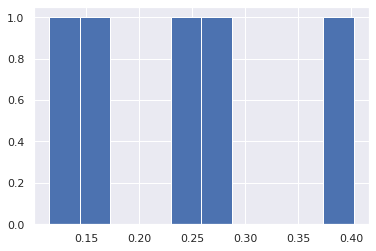

In [ ]:
(log_rend_b.mean()*252).hist()

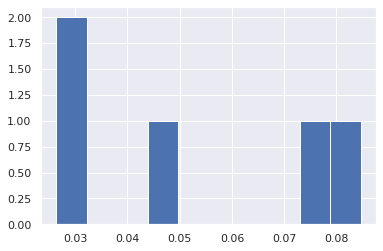

In [ ]:
(log_rend_b.var()*252).hist()

## Comparando mejores portafolios 2 objetivos contra 3 objetivos

In [ ]:
#Nos quedamos con los rendimientos de solo los mejores assets
log_rend_b = log_rend.loc[:, best_assets_l]
sp500_esgdat_b = sp500_esgdat.set_index('Symbol').loc[best_assets_l]

In [ ]:
means = log_rend_b.mean().to_numpy()
cov_matrix = log_rend_b.cov().to_numpy()
esg_scores =sp500_esgdat_b.loc[log_rend_b.columns]['ESGscore'].to_numpy()

https://pymoo.org/misc/reference_directions.html

Se construyen los pesos de los portafolios, deben sumar 1 son el porcentaje que el inversionista pone sobre cada activo del monto total dela inversión a generar. 

In [ ]:
#Esta función se ajusta a mano dependiendo de cuantos activos tengas
ref_dirs = get_reference_directions("uniform", len(means), n_points=101270)
len(ref_dirs)

101270

In [ ]:
dict_weights = { i:ref_dirs[i] for i in range(len(ref_dirs))}

In [ ]:
dict_weights[0] #Por ejemplo el primer portafolio es el 27avo activo de forma individual

array([0., 0., 0., 0., 1.])

In [ ]:
#Se construyen los valores de los portafolios 
#Beneficio, Riesgo, Impacto Sustentable
portfolios =[]
for props in tqdm(ref_dirs): 
    new_portfolio = [ -means@props, np.sqrt(props@cov_matrix@props), esg_scores@props]
    portfolios.append(new_portfolio)

portfolios = pd.DataFrame(portfolios, columns=['Profit', 'Risk', 'ESG'])

100%|██████████| 101270/101270 [00:00<00:00, 112296.39it/s]


In [ ]:
portfolios

,Profit,Risk,ESG
0,-0.001597,0.018327,37.610000
1,-0.001582,0.018042,37.300541
2,-0.001567,0.017768,36.991081
3,-0.001552,0.017504,36.681622
4,-0.001537,0.017252,36.372162
...,...,...,...
101265,-0.000973,0.013505,18.082432
101266,-0.000958,0.013544,17.772973
101267,-0.000942,0.013511,17.743784
101268,-0.000946,0.013506,17.735946


In [ ]:
best_2d = get_best_opt(portfolios,2, 1e-5) #beneficio y riesgo
best_3d = get_best_opt(portfolios,3, 1e-5) # beneficio, riesgo, impacto ESG

101270it [00:05, 18081.90it/s]
101270it [01:00, 1681.33it/s]


In [ ]:
best_2d.shape

(788, 2)

In [ ]:
best_3d.shape

(8671, 3)

## Análisis de los resultados

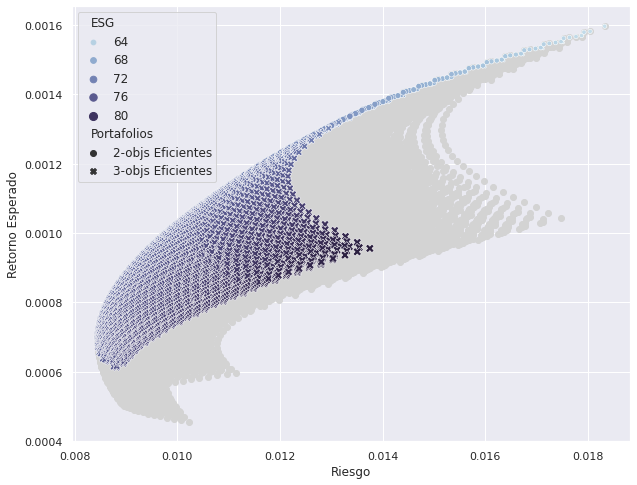

In [ ]:
portfolios_plot = portfolios.copy()
#portfolios_plot['Portafolios'] = np.NaN
portfolios_plot['Profit'] = -portfolios_plot['Profit']
portfolios_plot['ESG'] = (100-portfolios_plot['ESG'])
portfolios_plot.loc[best_3d.index,'Portafolios']='3-objs Eficientes'
portfolios_plot.loc[best_2d.index,'Portafolios'] ='2-objs Eficientes'
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(portfolios_plot['Risk'], portfolios_plot['Profit'], c='lightgray')
sns.scatterplot(data=portfolios_plot, x='Risk', y='Profit',style='Portafolios', hue='ESG', size='ESG', palette="ch:s=.25,rot=-.25",
                style_order= ['2-objs Eficientes','3-objs Eficientes'])
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.show()

In [ ]:
portfolios_plot.describe()

,Profit,Risk,ESG
count,101270.000000,101270.000000,101270.000000
mean,0.000930,0.010619,73.764000
std,0.000173,0.001462,2.808254
min,0.000456,0.008443,62.390000
25%,0.000807,0.009503,72.088378
50%,0.000920,0.010303,74.065946
75%,0.001040,0.011432,75.598919
max,0.001597,0.018327,82.460000


In [ ]:
portfolios_plot.loc[best_2d.index,:].describe()

,Profit,Risk,ESG
count,788.000000,788.000000,788.000000
mean,0.001066,0.010695,71.800847
std,0.000196,0.001957,1.934723
min,0.000697,0.008443,62.390000
25%,0.000919,0.009201,71.501014
50%,0.001062,0.010295,72.268649
75%,0.001189,0.011550,72.904189
max,0.001597,0.018327,74.106757


In [ ]:
portfolios_plot.loc[best_3d.index,:].describe()

,Profit,Risk,ESG
count,8671.000000,8671.000000,8671.000000
mean,0.000940,0.010382,76.208871
std,0.000142,0.001144,2.466157
min,0.000612,0.008443,62.390000
25%,0.000842,0.009521,74.537568
50%,0.000931,0.010299,76.335405
75%,0.001026,0.011112,78.005000
max,0.001597,0.018327,82.460000


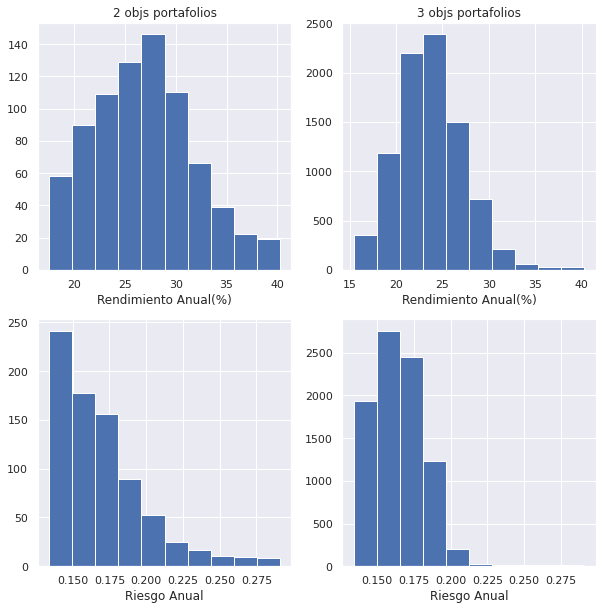

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0][0].set_title('2 objs portafolios')
ax[0][1].set_title('3 objs portafolios')
ax[0][0].set_xlabel('Rendimiento Anual(%)')
ax[0][1].set_xlabel('Rendimiento Anual(%)')
ax[1][0].set_xlabel('Riesgo Anual')
ax[1][1].set_xlabel('Riesgo Anual')
(-252*100*best_2d['Profit']).hist(ax=ax[0][0])
(-252*100*best_3d['Profit']).hist(ax=ax[0][1])
(np.sqrt(252)*best_2d['Risk']).hist(ax=ax[1][0])
(np.sqrt(252)*best_3d['Risk']).hist(ax=ax[1][1])

### Composición de las carteras eficientes

In [ ]:
def get_composition(portfs, idx_assets_dict, dict_weights): 
  apportation ={}
  for port_ind in portfs.index: 
    for i, val in enumerate(dict_weights[port_ind]): 
      if val>0:
        apportation[idx_assets_dict[i]] = apportation.get(idx_assets_dict[i], 0) + val*100
  df_apport = pd.Series(apportation).sort_values(ascending=False)
  df_apport = df_apport/len(portfs)
  return df_apport

In [ ]:
idx_assets_dict = { i : name for  i, name in enumerate(log_rend_b.columns)}

In [ ]:
df_apport_2d = get_composition(best_2d, idx_assets_dict, dict_weights)
df_apport_3d = get_composition(best_3d, idx_assets_dict, dict_weights)

df_apport_2d = df_apport_2d.reset_index()
df_apport_2d.columns = ['Symbol', 'Apport']
df_apport_2d['ESG'] = (100 -sp500_esgdat.set_index('Symbol').loc[ df_apport_2d['Symbol']]['ESGscore']).to_list()
df_apport_2d.set_index('Symbol', inplace=True)
df_apport_3d = df_apport_3d.reset_index()
df_apport_3d.columns = ['Symbol', 'Apport']
df_apport_3d['ESG'] = (100- sp500_esgdat.set_index('Symbol').loc[ df_apport_3d['Symbol']]['ESGscore']).to_list()
df_apport_3d.set_index('Symbol', inplace=True)

Text(0.5, 1.0, 'Composición de 3 objs Portafolios')

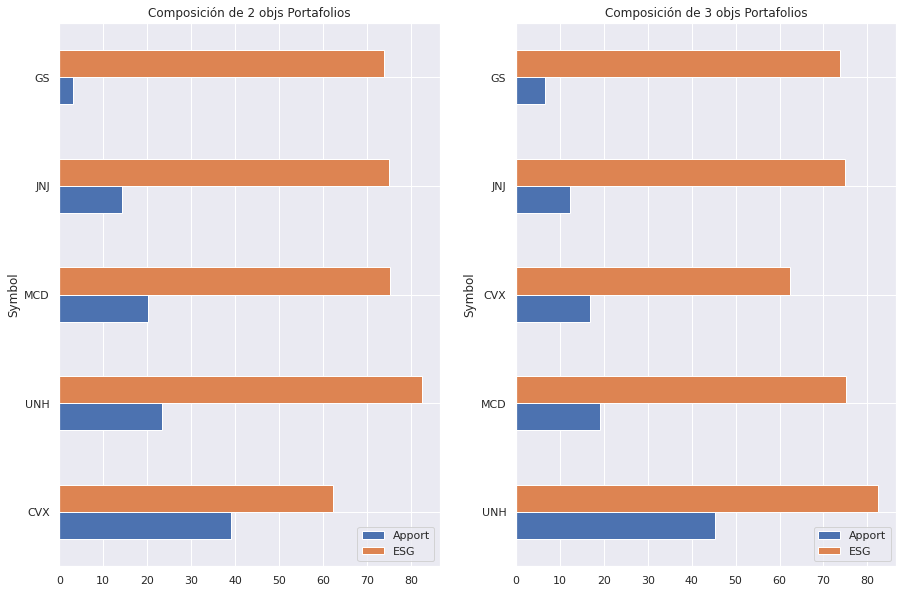

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,10))
df_apport_2d.plot(kind='barh', ax=ax[0])
df_apport_3d.plot(kind='barh', ax=ax[1])
ax[0].set_title('Composición de 2 objs Portafolios')
ax[1].set_title('Composición de 3 objs Portafolios')